In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_location = "/workspace/HRV/탭넷/fonts/NanumGothic-Regular.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

In [10]:
import sys
sys.path.append('/workspace/HRV')
from utils.imports import *
from utils.func import *
from utils.various_models import *
from utils.corr_vif import *
from utils.delete_feature import *
import itertools
from utils.figure import *
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score
from pytorch_tabnet.tab_model import TabNetClassifier
import json
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
import torch
#  GPU 및 PyTorch 최적화 설정
torch.set_num_threads(torch.get_num_threads())
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
os.environ["OMP_NUM_THREADS"] = str(torch.get_num_threads())
os.environ["MKL_NUM_THREADS"] = str(torch.get_num_threads())
os.environ["NUMEXPR_MAX_THREADS"] = str(torch.get_num_threads())
from IPython.display import display
import shap
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from 

In [11]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.1.2+cu121
12.1
True
1


In [12]:
another_target = ['PSS', 'AB' , 'CES', 'state_anx', 'BFI'] # FSS외 target 후보 변수
df = pd.read_csv('../../초반 코드/data1.csv')
df.columns = df.columns.str.replace(' ', '_')
df.drop(columns = '수진당시나이',inplace = True)
df.drop(columns = another_target, inplace = True)
print(df.columns)
df.drop(columns='피로도', inplace = True)
'''
cortisol 추가 시도 
해당 수치 없는 사람은 버리지 않고 mice 로 예측
'''
col_list = {'num_col': ['Age',  '자율신경 활성도',  '자율신경 균형도',  '스트레스 저항도',  '스트레스 지수',  '피로도',  '평균 심박동수',  '심장 안정도',  'Sdnn',  'Psi',  'Tp',  'Vlf',  'Lf',  'Hf',  'LfNorm',  'HfNorm',  'Lf/Hf',  'Rmssd',  'Apen',  'Srd',  'Tsrd',  'Tp(ln)',  'Vlf(ln)',  'Lf(ln)',  'Hf(ln)',  '수진당시나이',  '25-Hydroxy Vitamin D (Total)',  'Albumin',  'Free T4',  'GGT',  'GOT (AST)',  'GPT (ALT)',  'Glucose',  'Hb',  'HbA1c-NGSP',  'LDL-Cholesterol',  'TSH',  'TG',  'eGFR'],
 'cat_col': ['Sex', 'PSS', 'AB', 'FSS', 'CES', 'BFI'],
 'cat_col_ord': [],
 'label': ['state_anx'],
 'drop_col': ['ChartID',  'PersonalID',  '환자번호',  '측정센서',  '25-Hydroxy Vitamin D (D3/D2)',  '등록번호_확인',  'Date']}
res = pd.read_excel('../../초반 코드/HRV_Cortisol_241218.xlsx')
res_num = pd.read_excel('../../초반 코드/final_data.xlsx')
df['Chart_ID'] = res_num['ChartID']
df['Date'] = res_num['Date']
res_unique = res.drop_duplicates(subset=["환자번호", "검진 시행일자","검사 세부 항목명"], keep="first")
res_wide = res_unique.pivot(
    index=["환자번호", "검진 시행일자"],
    columns=["검사 세부 항목명"],
    values="검사결과"
).reset_index()
res_wide["Chart ID"] = res_wide.groupby("환자번호")["환자번호 <- 상부위장관 내시경(위) 결과지  <- 과별서식기본"].transform(lambda group: group.ffill().bfill())
columns = ["Chart ID"] + [col for col in res_wide.columns if col != "Chart ID"]  # 열 순서 정의
res_wide = res_wide[columns]
res_wide['Chart ID'] = res_wide['Chart ID'].astype('int64')
res_wide.columns = res_wide.columns.str.replace(' ', '_')
res_wide.columns = ['Chart_ID', '환자번호', '검진_시행일자','Cortisol(핵의학)','환자번호_<-_상부위장관_내시경(위)_결과지__<-_과별서식기본']
df['Date'] = pd.to_datetime(df['Date'])
merged_df = pd.merge(
    df, 
    res_wide[['Chart_ID', '검진_시행일자', 'Cortisol(핵의학)']], 
    left_on=['Chart_ID', 'Date'],
    right_on=['Chart_ID', '검진_시행일자'],
    how='left'  
)
merged_df.drop(columns = ['Date', 'Chart_ID','검진_시행일자'],inplace = True)
print(merged_df.shape)
col_list['num_col'].append('Cortisol(핵의학)')
nac = merged_df.isna().sum()
print(nac[nac > 0]) # nan값 없음
df = merged_df.copy()
blood = ['25-Hydroxy_Vitamin_D_(Total)','Albumin','Free_T4','GGT','GOT_(AST)','GPT_(ALT)','Glucose','Hb','HbA1c-NGSP','LDL-Cholesterol','TSH','TG']
df.drop(columns=blood, inplace = True)
print(df.columns)
num_cols=['Age','자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '평균_심박동수',
      '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm', 'HfNorm',
      'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)', 'Lf(ln)',
      'Hf(ln)', 'eGFR','Cortisol(핵의학)']
cat_cols = ['Sex']
targets= ['BFI']
features = num_cols.copy()
df['Cortisol_missing'] = df['Cortisol(핵의학)'].isnull().astype(int) 

Index(['Age', 'Sex', '자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '피로도',
       '평균_심박동수', '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm',
       'HfNorm', 'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)',
       'Lf(ln)', 'Hf(ln)', 'FSS', '25-Hydroxy_Vitamin_D_(Total)', 'Albumin',
       'Free_T4', 'GGT', 'GOT_(AST)', 'GPT_(ALT)', 'Glucose', 'Hb',
       'HbA1c-NGSP', 'LDL-Cholesterol', 'TSH', 'TG', 'eGFR'],
      dtype='object')
(336, 40)
Cortisol(핵의학)    108
dtype: int64
Index(['Age', 'Sex', '자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '평균_심박동수',
       '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm', 'HfNorm',
       'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)', 'Lf(ln)',
       'Hf(ln)', 'FSS', 'eGFR', 'Cortisol(핵의학)'],
      dtype='object')


In [ ]:
target = 'FSS'
X = df.drop(columns=[target])
y = df[target].astype(int)  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

features = ['Age', 'Sex', '자율신경_활성도', '자율신경_균형도',
            '스트레스_저항도', '스트레스_지수', '평균_심박동수',
            '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf',
            'LfNorm', 'HfNorm', 'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd',
            'Tp(ln)', 'Vlf(ln)', 'Lf(ln)', 'Hf(ln)']

num_features = ['Age',  '자율신경_활성도', '자율신경_균형도',
            '스트레스_저항도', '스트레스_지수', '평균_심박동수',
            '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf',
            'LfNorm', 'HfNorm', 'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd',
            'Tp(ln)', 'Vlf(ln)', 'Lf(ln)', 'Hf(ln)']
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

X_train = X_train[features]
X_test = X_test[features]

def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 2, 30),
        "n_a": trial.suggest_int("n_a", 2, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05, log=True),  
        "gamma": trial.suggest_float("gamma", 1.0, 1.5),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-1, log=True),
        "momentum": trial.suggest_float("momentum", 0.02, 0.3),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "mask_type": "entmax",
        "optimizer_params": {"lr": trial.suggest_float("optimizer_lr", 0.001, 0.01, log=True)}
    }
    batch_size = trial.suggest_int("batch_size", 32, 60)
    virtual_batch_size =  batch_size // 4
    auc_scores = []

    for train_index, valid_index in kf.split(X_train, y_train):
        X_train_k = X_train.iloc[train_index].copy()
        X_valid_k = X_train.iloc[valid_index].copy()
        y_train_k = y_train.iloc[train_index].astype(int)
        y_valid_k = y_train.iloc[valid_index].astype(int)
        
        scaler_kfold  = StandardScaler() 
        X_train_k[num_features] = scaler_kfold.fit_transform(X_train_k[num_features])
        X_valid_k[num_features] = scaler_kfold.transform(X_valid_k[num_features])

        model1 = TabNetClassifier(
            n_d=params["n_d"],
            n_a=params["n_a"],
            n_steps=params["n_steps"],
            gamma=params["gamma"],
            lambda_sparse=params["lambda_sparse"],
            optimizer_params=params["optimizer_params"],
            mask_type=params["mask_type"],
            momentum=params["momentum"],
            device_name="cuda" if torch.cuda.is_available() else "cpu",
            verbose = 0
        )

        model1.fit(
            X_train=X_train_k.values, y_train=y_train_k.values.ravel(),
            eval_set=[(X_valid_k.values, y_valid_k.values.ravel())],
            eval_metric=["auc"],
            batch_size=batch_size,
            virtual_batch_size=virtual_batch_size,
            max_epochs=300, patience=200, 
        )

        y_proba_k = model1.predict_proba(X_valid_k.values)[:, 1]

        auc = roc_auc_score(y_valid_k, y_proba_k)
        auc_scores.append(auc)
        
    val_auc = np.mean(auc_scores)
        
    return val_auc

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)  

print("Best hyperparameters: ", study.best_params)
# 로깅 남겨서 백그라운드에서 돌림

In [14]:
param = study.best_params #{'n_d': 13, 'n_a': 11, 'learning_rate': 0.015616853089587157, 'gamma': 1.2752154118458399, 'lambda_sparse': 0.00023317059931811325, 'momentum': 0.2520092584162361, 'n_steps': 8, 'optimizer_lr': 0.002875927251289799, 'batch_size': 56}
batch_size = param['batch_size']
virtual_batch_size = batch_size // 4
# param에서 batch_size 제거
del param['batch_size']
param['mask_type'] = 'entmax'
param['device_name']="cuda" if torch.cuda.is_available() else "cpu"
param['verbose'] = 0

In [15]:
target = 'FSS'
X = df.drop(columns=[target])
y = df[target].astype(int)  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

features = ['Age', 'Sex', '자율신경_활성도', '자율신경_균형도',
            '스트레스_저항도', '스트레스_지수', '평균_심박동수',
            '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf',
            'LfNorm', 'HfNorm', 'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd',
            'Tp(ln)', 'Vlf(ln)', 'Lf(ln)', 'Hf(ln)']

num_features = ['Age',  '자율신경_활성도', '자율신경_균형도',
            '스트레스_저항도', '스트레스_지수', '평균_심박동수',
            '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf',
            'LfNorm', 'HfNorm', 'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd',
            'Tp(ln)', 'Vlf(ln)', 'Lf(ln)', 'Hf(ln)']
X_train = X_train[features]
X_test = X_test[features]

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

auc_scores = []

for train_index, valid_index in kf.split(X_train, y_train):
    X_train_k = X_train.iloc[train_index].copy()
    X_valid_k = X_train.iloc[valid_index].copy()
    y_train_k = y_train.iloc[train_index].astype(int)
    y_valid_k = y_train.iloc[valid_index].astype(int)
    
    scaler_kfold  = StandardScaler() 
    X_train_k[num_features] = scaler_kfold.fit_transform(X_train_k[num_features])
    X_valid_k[num_features] = scaler_kfold.transform(X_valid_k[num_features])

    model = TabNetClassifier(
        n_d=param["n_d"],
        n_a=param["n_a"],
        n_steps=param["n_steps"],
        gamma=param["gamma"],
        lambda_sparse=param["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,  
        optimizer_params={"lr": param["optimizer_lr"]},  
        mask_type=param["mask_type"],
        momentum=param["momentum"],
        device_name="cuda" if torch.cuda.is_available() else "cpu",
        verbose = 0
    )

    model.fit(
        X_train=X_train_k.values, y_train=y_train_k.values.ravel(),
        eval_set=[(X_valid_k.values, y_valid_k.values.ravel())],
        eval_metric=["auc"],
        batch_size=batch_size,
        virtual_batch_size=virtual_batch_size,
        max_epochs=300, patience=200, 
    )

    y_proba_k = model.predict_proba(X_valid_k.values)[:, 1]

    auc = roc_auc_score(y_valid_k, y_proba_k)
    auc_scores.append(auc)
    
val_auc = np.mean(auc_scores)
    

X_train_all = X_train.copy()
X_test_all = X_test.copy()

scaler = StandardScaler() 
X_train_all[num_features] = scaler.fit_transform(X_train_all[num_features])
X_test_all[num_features] = scaler.transform(X_test_all[num_features])    
model = TabNetClassifier(
    n_d=param["n_d"],
    n_a=param["n_a"],
    n_steps=param["n_steps"],
    gamma=param["gamma"],
    lambda_sparse=param["lambda_sparse"],
    optimizer_fn=torch.optim.Adam, 
    optimizer_params={"lr": param["optimizer_lr"]}, 
    mask_type=param["mask_type"],
    momentum=param["momentum"],
    device_name="cuda" if torch.cuda.is_available() else "cpu",
    verbose = 0
)
model.fit(X_train = X_train_all.values, y_train = y_train.values.ravel(), 
            eval_set=[(X_test_all.values, y_test.values.ravel())], 
            eval_metric=["auc"], 
            batch_size=batch_size,
            virtual_batch_size=virtual_batch_size,
            max_epochs=300, patience=200,
            )
y_proba = model.predict_proba(X_test_all.values)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)
print(f"Test AUC: {BRIGHT_YELLOW}{test_auc}{BRIGHT_END}")
print(f"Validation AUC: {BRIGHT_RED}{val_auc}{BRIGHT_END}")

Stop training because you reached max_epochs = 300 with best_epoch = 183 and best_val_0_auc = 0.72138
Stop training because you reached max_epochs = 300 with best_epoch = 182 and best_val_0_auc = 0.74069

Early stopping occurred at epoch 208 with best_epoch = 8 and best_val_0_auc = 0.69931
Stop training because you reached max_epochs = 300 with best_epoch = 261 and best_val_0_auc = 0.84286

Early stopping occurred at epoch 216 with best_epoch = 16 and best_val_0_auc = 0.71264
Stop training because you reached max_epochs = 300 with best_epoch = 184 and best_val_0_auc = 0.77431
Test AUC: 0.7743055555555556
Validation AUC: 0.743376026272578


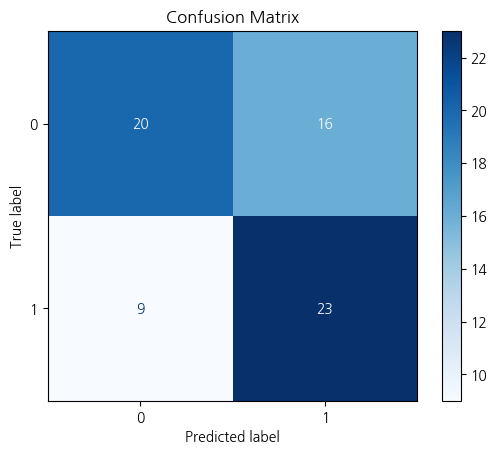

오차행렬:
 [[20 16]
 [ 9 23]]

정확도: 0.6324
정밀도: 0.5897
재현율: 0.7188
F1: 0.6479


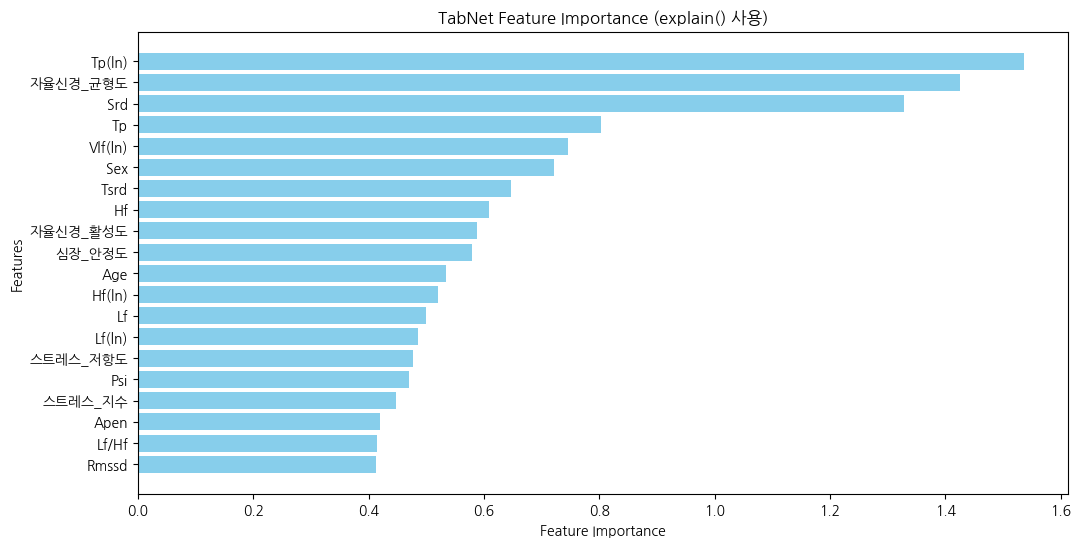

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_all.values)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
get_clf_eval(y_test, y_pred)
explain_matrix, masks = model.explain(X_test_all.values)
feature_importance = explain_matrix.mean(axis=0)  # 평균 중요도 계산
sorted_idx = np.argsort(feature_importance)[::-1]  # 내림차순 정렬
sorted_features = X_train_all.columns[sorted_idx][:20]
sorted_importance = feature_importance[sorted_idx][:20]

plt.figure(figsize=(12, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("TabNet Feature Importance (explain() 사용)")
plt.gca().invert_yaxis()  
plt.show()
# TabNet의 Feature Importance 값은 모델이 예측을 수행하는 과정에서 해당 변수를 얼마나 자주 사용했는지를 측정한 것
# 자주 사용된다고 해서 반드시 중요한 변수라고 단정할 수는 없음
# 특정 Feature가 자주 선택되지만 실제로 성능 향상에 기여하지 않는다면?
# 그 Feature가 중요한 것이 아닐 수도 있음
# 단순히 모델이 자주 활용했을 뿐, 실제 예측력에는 영향이 적을 수도 있음
# TabNet Feature Importance만으로는 실제 예측력에 대한 기여도를 알 수 없음
# 그러므로 SHAP 분석을 함께 활용하는 것이 중요

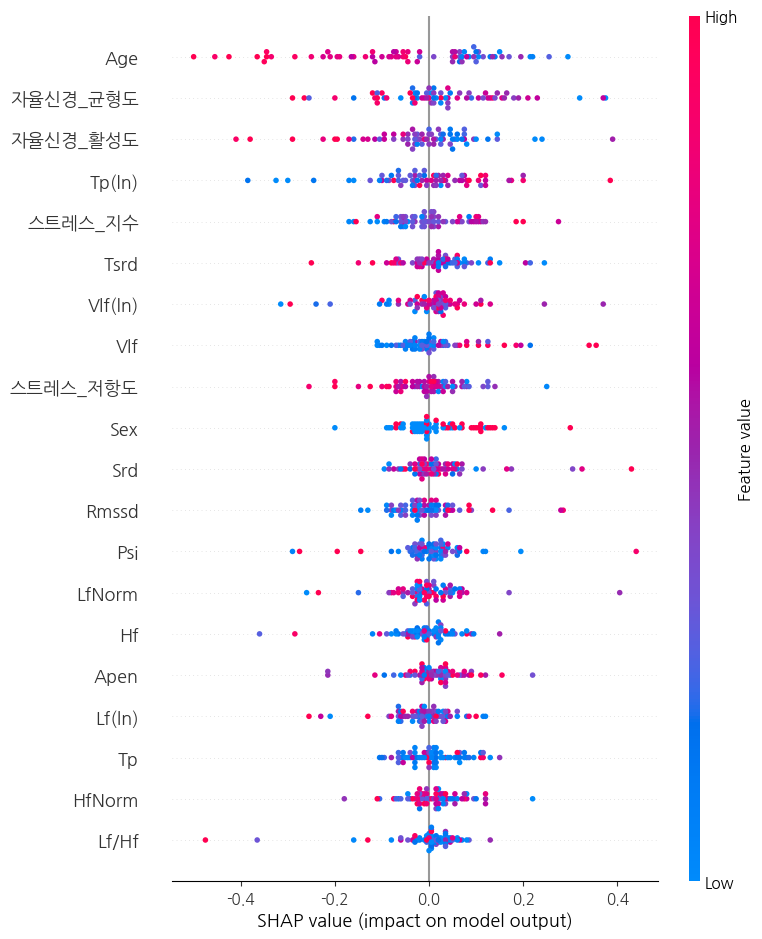

,Feature,Mean_Abs_SHAP
0,Age,0.146838
3,자율신경_균형도,0.096029
2,자율신경_활성도,0.086029
21,Tp(ln),0.084632
5,스트레스_지수,0.064265
20,Tsrd,0.059853
22,Vlf(ln),0.059706
11,Vlf,0.059118
4,스트레스_저항도,0.056691
1,Sex,0.055000


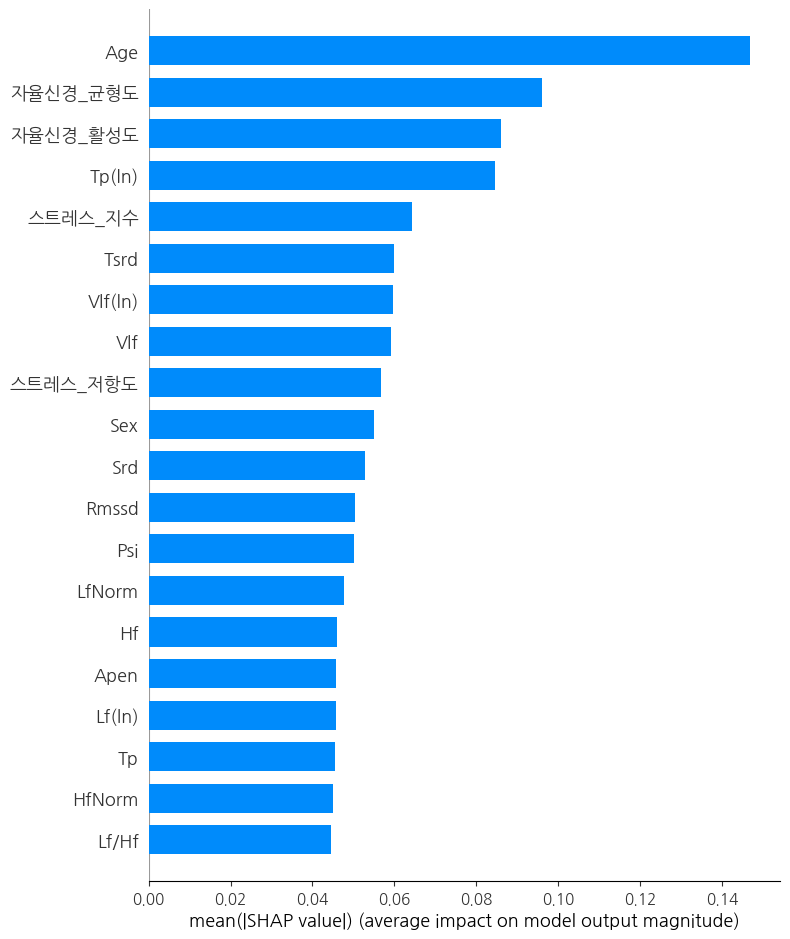

In [18]:
# SHAP은 모델이 각 Feature의 예측값에 미치는 영향을 수량적으로 분석할 수 있음
# SHAP Summary Plot에서 높은 Feature가 진짜 중요한 변수
# TabNet Feature Importance가 높지만 SHAP에서 영향이 적다면, 중요하지 않을 수도 있음

explainer = shap.Explainer(model.predict, X_train_all.values, max_evals=100,approximate=True )
shap_values = explainer(X_test_all.values)
shap.summary_plot(shap_values, X_test_all, feature_names=X_train_all.columns)
mean_shap = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X_train_all.columns,
    'Mean_Abs_SHAP': mean_shap
}).sort_values(by='Mean_Abs_SHAP', ascending=False)

display(importance_df)

shap.summary_plot(shap_values, X_test_all, plot_type = 'bar', 
                  feature_names=X_test_all.columns)

from IPython.display import HTML
shap.initjs()
force_plot = shap.force_plot(shap_values.base_values , shap_values.values, 
                X_train_all,)
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot.html()}</div>")

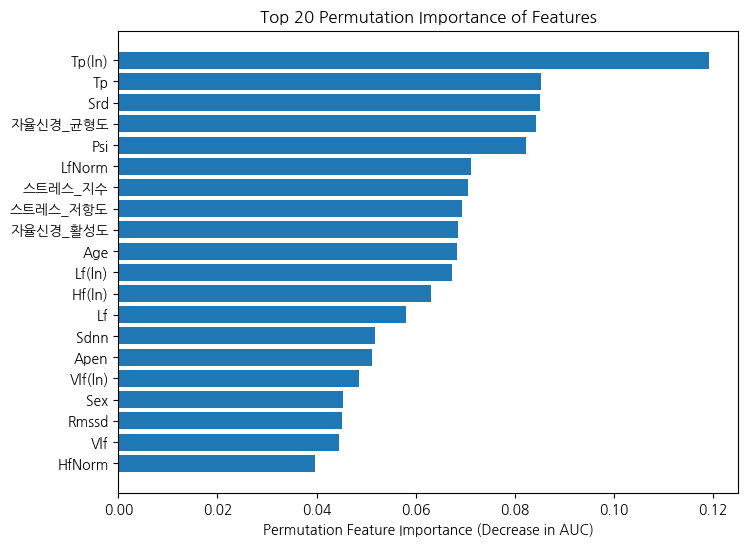

In [20]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    model, 
    X_test_all.values, 
    y_test, 
    scoring='roc_auc', 
    n_repeats=10, 
    random_state=42
)

sorted_idx = result.importances_mean.argsort()[::-1]
sorted_features = np.array(X_test_all.columns)[sorted_idx]
sorted_importances = result.importances_mean[sorted_idx]

top_n = 20
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

plt.figure(figsize=(8, 6)) 
plt.barh(range(len(top_features)), top_importances, align='center')
plt.yticks(range(len(top_features)), top_features)  
plt.xlabel("Permutation Feature Importance (Decrease in AUC)")
plt.title(f"Top {top_n} Permutation Importance of Features")
plt.gca().invert_yaxis()  
plt.show()

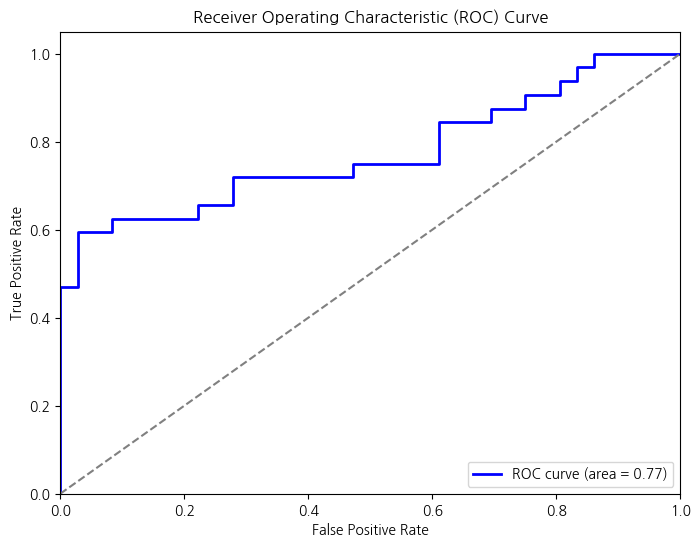

In [22]:
from sklearn.metrics import roc_curve, auc

# 실제 값과 예측 확률
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()